# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#1
#Package Imports
#All the necessary packages and modules are imported in the first cell of the notebook

# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import os, random
from PIL import Image
from math import ceil
#Updated as review comment 
import json


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
training_dir = data_dir + '/train'
validation_dir = data_dir + '/valid'
testing_dir = data_dir + '/test'

In [3]:
# to show random images
def show_images(dataloader, image_type):
    images, labels = next(iter(dataloader))
    fig, ax = plt.subplots()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = images[0].numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.set_title("Random {}".format(image_type))
    ax.imshow(image)

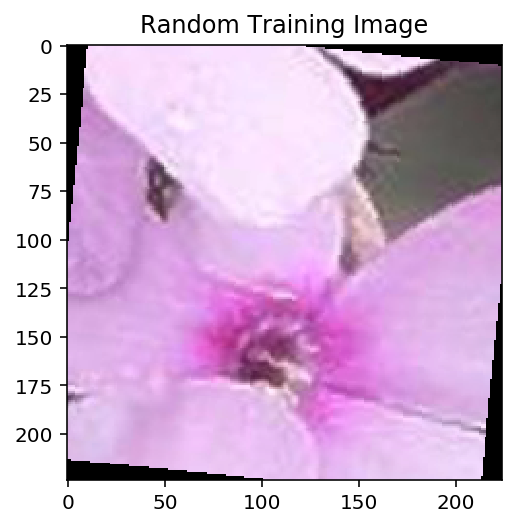

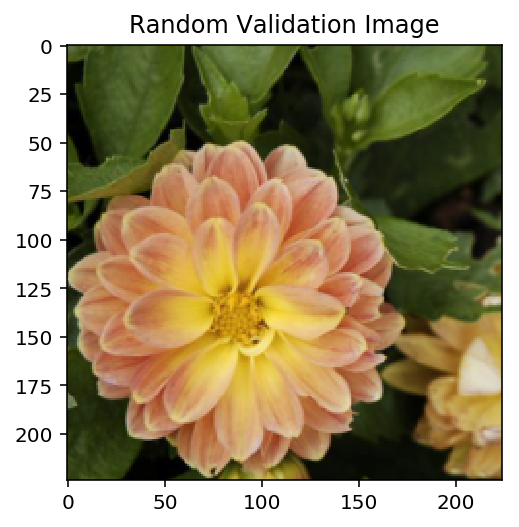

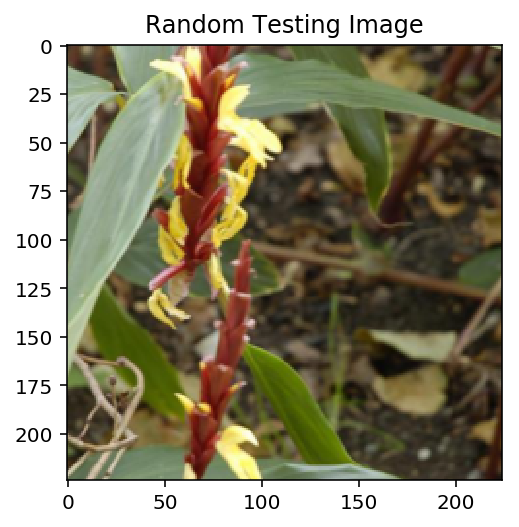

In [4]:
# Done: Define your transforms for the training, validation, and testing sets

#2
#Training data augmentation
#torchvision transforms are used to augment the training data with 
#random scaling, rotations, #mirroring, and/or cropping

#3
#Data normalization
#The training, validation, and testing data is appropriately cropped and normalized

#Updated as per Review Comment

training_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#4
#Data batching
#The data for each set is loaded with torchvision's DataLoader

# Done: Load the datasets with ImageFolder
#image_datasets for training validation and testing
training_set = datasets.ImageFolder(training_dir, transform = training_transforms)
validation_set = datasets.ImageFolder(validation_dir, transform = validation_transforms)
testing_set = datasets.ImageFolder(testing_dir, transform = testing_transforms)

#5
#Data loading
#The data for each set (train, validation, test) is loaded with torchvision's ImageFolder

# Done: Using the image datasets and the trainforms, define the dataloaders
#dataloaders for training validation and testing
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32,shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=32,shuffle=True)

# Optional to display images from these data loaders
show_images(training_loader,'Training Image')
show_images(validation_loader,'Validation Image')
show_images(testing_loader,'Testing Image')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
#Updated as review comment 
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
training_set.class_to_idx = cat_to_name
validation_set.class_to_idx = cat_to_name
testing_set.class_to_idx = cat_to_name

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
#To check and use cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:{}' .format(device))

Device:cuda:0


In [7]:
# Done: Build and train your network

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)





In [8]:
def train(model, trainloader, testloader, device,epochs=5, print_every=40, debug=0):
    
#    device = torch.device(device)
   
    #Setup training Parameters
    steps = 0
    running_loss = 0
    
    if(debug == 1):
        print("Epochs | Training Loss | Test Loss | Test Accuracy ")
    # Define the criterion and optimizer with the model and learning rate (0.001)
    criterion = nn.NLLLoss().to(device)
    # Only train the classifier parameters, feature parameters are frozen
    #optimizer = optim.Adam(list(model.classifier.parameters()), learning_rate)
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    # Send the model to the correct processor
    model.to(device)
        
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        
        for images, labels in trainloader:
            steps += 1
            
            images, labels = images.to(device), labels.to(device)            
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion,device)
                if(debug == 1):
                    print("{}/{} |".format(e+1, epochs),
                          "{:.3f} |".format(running_loss/print_every),
                          "{:.3f} | ".format(test_loss/len(testloader)),
                          "{:.3f} |".format(accuracy/len(testloader)))
                else:
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()
    # Return the accuracy in terms of a percentage
    return accuracy/len(testloader)

In [9]:
def validation(model, testloader, criterion, device = 'cpu'):
    accuracy = 0
    test_loss = 0
    # Send the model to the desired processor
    model.to(device)

    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

In [10]:
# This function is to make generic implementation to load torchvision models
def get_model(model_name):
    if model_name=='alexnet':
        model = models.alexnet(pretrained=True)
    elif model_name=='vgg19_bn':
        model = models.vgg19_bn(pretrained=True)
    elif model_name=='vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name=='vgg13':
        model = models.vgg13(pretrained=True)
    elif model_name=='vgg11':
        model = models.vgg11(pretrained=True)
    else:
        print("\nError: selecting default vgg16\n")
        model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    return model  
#End of get_model

In [11]:
#6
#Pretrained Network
#A pretrained network such as VGG16 is loaded from torchvision.models and the parameters are frozen

hidden_units = [4096,4096]
architecture = 'vgg16'
epochs = 10
drop_p = 0.2
learning_rate = 0.001

model = get_model(architecture)
#model = models.vgg16(pretrained=True)
classifier_modules = [type(model.classifier[i]).__name__ for i in range(len(model.classifier))]
First_Linear_Module = classifier_modules.index('Linear')

# Create the classifier for the model 
# Use the transfer models outputs as inputs and the number of image categories as outputs
# classifier = Network(model.classifier[First_Linear_Module].in_features, len(train_dataset.classes), hidden_layers, dropout_probability)
classifier = Network(model.classifier[First_Linear_Module].in_features,102,hidden_units, drop_p = 0.2)


# Attach the classifier to the model
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [12]:
#7
#Feedforward Classifier
#A new feedforward network is defined for use as a classifier using the features as input
#Display VGG Model
# here's a routine to check the feed-forward timing of each processor
for processor in ['cpu', 'cuda']:
    print(processor)
    
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    model.to(processor)
    
    start = time.time()
    for ii, (inputs, labels) in enumerate(training_loader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(processor), labels.to(processor)

        print("Executing forward pass {} ...".format(ii+1))
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==2:
            break

    total_time = time.time()-start
    print(f"Device = {processor}; Time per batch: {total_time/3:.3f} seconds")


cpu
Executing forward pass 1 ...
Executing forward pass 2 ...
Executing forward pass 3 ...
Device = cpu; Time per batch: 20.139 seconds
cuda
Executing forward pass 1 ...
Executing forward pass 2 ...
Executing forward pass 3 ...
Device = cuda; Time per batch: 0.488 seconds


In [13]:
#8
#Training the network
#The parameters of the feedforward classifier are appropriately trained, while the parameters of the feature network are left static

model_accuracy = train(model, training_loader, testing_loader, device, epochs, debug=0)

Epoch: 1/10..  Training Loss: 4.390..  Test Loss: 3.780..  Test Accuracy: 0.148
Epoch: 1/10..  Training Loss: 3.585..  Test Loss: 2.711..  Test Accuracy: 0.333
Epoch: 1/10..  Training Loss: 3.019..  Test Loss: 2.293..  Test Accuracy: 0.400
Epoch: 1/10..  Training Loss: 2.710..  Test Loss: 2.105..  Test Accuracy: 0.451
Epoch: 1/10..  Training Loss: 2.684..  Test Loss: 1.932..  Test Accuracy: 0.477
Epoch: 2/10..  Training Loss: 2.298..  Test Loss: 1.733..  Test Accuracy: 0.517
Epoch: 2/10..  Training Loss: 2.359..  Test Loss: 1.639..  Test Accuracy: 0.548
Epoch: 2/10..  Training Loss: 2.205..  Test Loss: 1.501..  Test Accuracy: 0.568
Epoch: 2/10..  Training Loss: 2.021..  Test Loss: 1.364..  Test Accuracy: 0.627
Epoch: 2/10..  Training Loss: 2.158..  Test Loss: 1.483..  Test Accuracy: 0.608
Epoch: 3/10..  Training Loss: 2.043..  Test Loss: 1.536..  Test Accuracy: 0.600
Epoch: 3/10..  Training Loss: 2.068..  Test Loss: 1.315..  Test Accuracy: 0.644
Epoch: 3/10..  Training Loss: 2.071..  T

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set
# Put the model in eval mode and turn off gradients
#9
#Testing Accuracy
#The network's accuracy is measured on the test data

model.eval()
eval_start = time.time()
with torch.no_grad():
    # Do a validation
    test_loss, accuracy = validation(model, testing_loader, criterion, device)
eval_time = time.time()-eval_start
print("Test Loss: {:.3f}.. ".format(test_loss/len(testing_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testing_loader)),
      "-- Time: {:>10.3f}".format(eval_time)
     )


Test Loss: 0.844..  Test Accuracy: 0.771 -- Time:     18.211


In [15]:
#10
#Validation Loss and Accuracy
#During training, the validation loss and accuracy are displayed

model.eval()
eval_start = time.time()
with torch.no_grad():
    # Do a validation
    test_loss, accuracy = validation(model, validation_loader, criterion, device)
eval_time = time.time()-eval_start
print("Validation Loss: {:.3f}.. ".format(test_loss/len(validation_loader)),
      "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)),
      "-- Time: {:>10.3f}".format(eval_time)
     )


Validation Loss: 0.769..  Validation Accuracy: 0.796 -- Time:     18.132


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
def save_checkpoint(filepath, model, transfer_model_name, input_size, output_size, hyperparams, model_accuracy):
    checkpoint = {'transfer_model_name': transfer_model_name,
                  'input_size': input_size,
                  'output_size': output_size,
                  'hidden_layers': hyperparams['hidden_layers'],
                  'drop_p': hyperparams['dropout_probability'],
                  'learnrate': hyperparams['learnrate'],
                  'epochs': hyperparams['epochs'],
                  'model_accuracy': model_accuracy,
                  'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)

In [17]:
# TODO: Save the checkpoint 
checkpoint_path = 'image_classifier_model/checkpoint.pth'
print ('Saving checkpoint to:', checkpoint_path) 
# Store class_to_idx into a model property

hyperparameters = {'architecture': architecture,
                   'hidden_layers': hidden_units,
                   'dropout_probability': drop_p,
                   'learnrate': learning_rate,
                   'epochs': epochs}

save_checkpoint(checkpoint_path, model, hyperparameters['architecture'], 
                model.classifier.hidden_layers[0].in_features, 
                model.classifier.output.out_features, 
                hyperparameters, 
                model_accuracy)

Saving checkpoint to: image_classifier_model/checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model_name = checkpoint['transfer_model_name']
   
    model = get_model(model_name)
    
    classifier = Network(checkpoint['input_size'],
                         checkpoint['output_size'],
                         checkpoint['hidden_layers'],
                         checkpoint['drop_p'])
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    hidden_layers = checkpoint['hidden_layers']
    dropout_probability = checkpoint['drop_p']
    learnrate = checkpoint['learnrate']
    epochs = checkpoint['epochs']
    accuracy = checkpoint['model_accuracy']
    
    return model, accuracy, learnrate

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint_path = 'image_classifier_model/checkpoint.pth'
# Load the checkpoint
model, accuracy, learnrate = load_checkpoint(checkpoint_path)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
def process_image(pil_image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Done: Process a PIL image for use in a PyTorch model
    # define transforms
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess the image
    img_tensor = preprocess(pil_image)
    
    # add dimension for batch
    img_tensor.unsqueeze_(0)
    
    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

flowers/test/61/image_06271.jpg


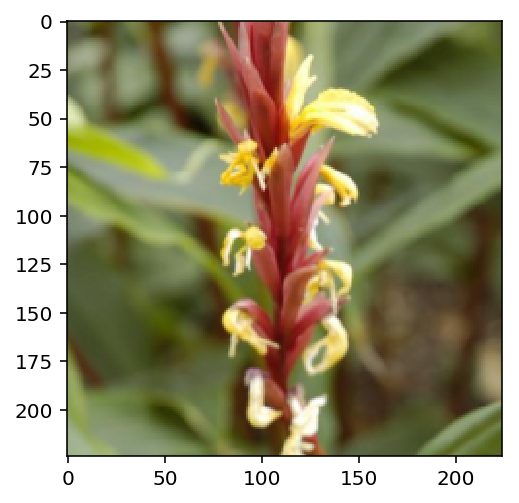

In [26]:
#Get random file name from test image directory and display...

file_name = random.choice(os.listdir(testing_dir)) #change dir name to whatever
file_path = testing_dir + '/'+ str(file_name)
file_name = testing_dir + '/'+ str(file_name) + '/' + str(random.choice(os.listdir(file_path))) #change dir name to whatever
print(file_name)
image=process_image(Image.open(file_name))
imshow(image[0])

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [27]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(Image.open(image_path))
    
    model.eval()
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learnrate)
    image = image.to(device)
    with torch.no_grad():
        output = model.forward(image)
        ps = torch.exp(output)

    topk_probs_tensor, topk_idx_tensor = ps.topk(topk)

    #probs = topk_probs_tensor.tolist()[0]
    #classes = [model.class_to_idx[str(sorted(model.class_to_idx)[i])] for i in (topk_idx_tensor).tolist()[0]]
    
    return topk_probs_tensor, topk_idx_tensor #probs, classes


[0.4641956388950348, 0.0658765435218811, 0.0557878352701664, 0.036595940589904785, 0.02693387120962143]
['cautleya spicata', 'fire lily', 'columbine', 'orange dahlia', 'cape flower']
flowers/test/61/image_06271.jpg


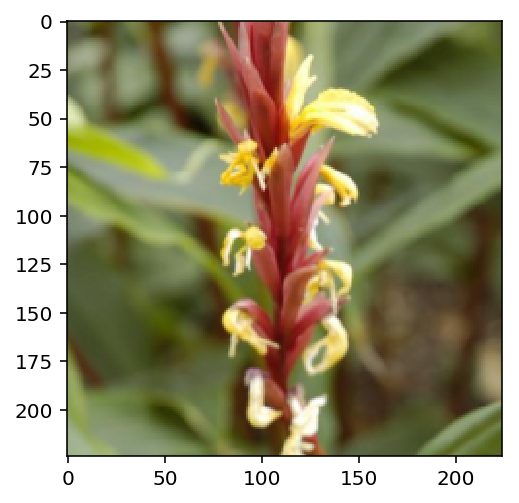

In [28]:
# get the probabilities and classes
top_k = 5
probs_tensor, classes_tensor = predict(file_name, model, topk=top_k)

# Convert the probabilities and classes tensors into lists
probs = probs_tensor.tolist()[0]
model.class_to_idx = cat_to_name
classes = [model.class_to_idx[str(sorted(model.class_to_idx)[i])] for i in (classes_tensor).tolist()[0]]

print(probs)
print(classes)
print(file_name)
image=process_image(Image.open(file_name))
imshow(image[0])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

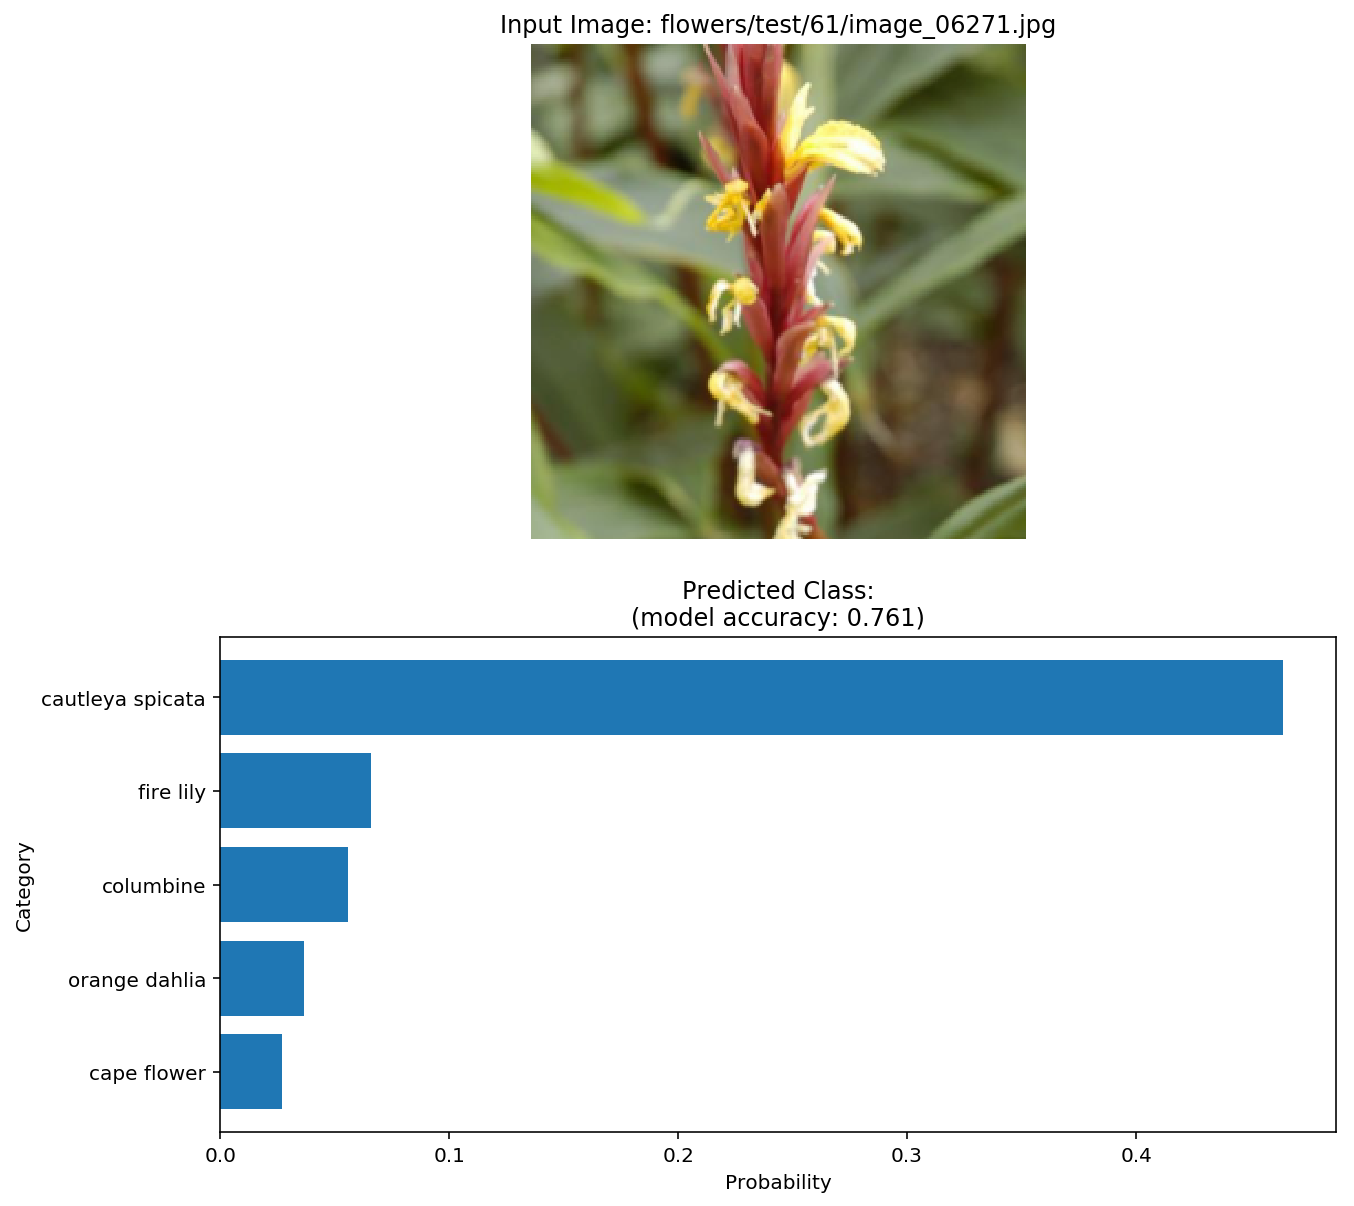

In [29]:
# TODO: Display an image along with the top 5 classes
# Plot the image and the top k probabilities in a horizontal bar chart
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), nrows=2)
ax1 = imshow(image[0], ax1)
ax1.axis('off')
ax1.set_title("Input Image: {}".format(file_name))
ax2.barh(-np.arange(top_k), probs, tick_label=classes)
ax2.set_title("Predicted Class:\n(model accuracy: {:.3f})".format(accuracy))
ax2.set_xlabel('Probability')
ax2.set_ylabel('Category')
plt.show()